In [1]:
import shared_functions as sf
import numpy as np
import datetime
import torch
import matplotlib.pyplot as plt

In [2]:
DIR_INPUT='../data/simulated-data-transformed/data/' 

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df=sf.read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

Load  files
CPU times: total: 172 ms
Wall time: 390 ms
919767 transactions loaded, containing 8195 fraudulent transactions


In [3]:
# Set the starting day for the training period, and the deltas
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train=7
delta_delay=7
delta_test=7


delta_valid = delta_test

start_date_training_with_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))

(train_df, valid_df) = sf.get_train_test_set(transactions_df,start_date_training_with_valid,
                                       delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)

# By default, scales input data
(train_df, valid_df) = sf.scaleData(train_df, valid_df,input_features)

In [4]:
SEED = 42

if torch.cuda.is_available():
    DEVICE = "cuda" 
else:
    DEVICE = "cpu"
print("Selected device is",DEVICE)

sf.seed_everything(SEED)

Selected device is cuda


In [5]:
x_train = torch.FloatTensor(train_df[input_features].values)
x_valid = torch.FloatTensor(valid_df[input_features].values)
y_train = torch.FloatTensor(train_df[output_feature].values)
y_valid = torch.FloatTensor(valid_df[output_feature].values)

In [6]:
class FraudDatasetUnsupervised(torch.utils.data.Dataset):
    
    def __init__(self, x,output=True):
        'Initialization'
        self.x = x
        self.output = output

    def __len__(self):
        'Returns the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample index
        item = self.x[index].to(DEVICE)
        if self.output:
            return item, item
        else:
            return item

In [7]:
training_set = FraudDatasetUnsupervised(x_train)
valid_set = FraudDatasetUnsupervised(x_valid)

In [8]:
training_generator,valid_generator = sf.prepare_generators(training_set, valid_set, batch_size = 64)

In [9]:
class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.relu = torch.nn.ReLU()   
            
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.relu(hidden)
            
            code = self.fc2(hidden)
            code = self.relu(code)
 
            hidden = self.fc3(code)
            hidden = self.relu(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output

In [10]:
criterion = torch.nn.MSELoss().to(DEVICE)

In [11]:
def per_sample_mse(model, generator):
    
    model.eval()
    criterion = torch.nn.MSELoss(reduction="none")
    batch_losses = []
    
    for x_batch, y_batch in generator:
        # Forward pass
        y_pred = model(x_batch)
        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_batch)
        loss_app = list(torch.mean(loss,axis=1).detach().cpu().numpy())
        batch_losses.extend(loss_app)
    
    return batch_losses

In [12]:
sf.seed_everything(SEED)
model = SimpleAutoencoder(x_train.shape[1], 100, 20).to(DEVICE)
losses = sf.per_sample_mse(model, valid_generator)

In [13]:
print(losses[0:5])
print(np.mean(losses))

[0.6754841, 0.7914626, 1.1697073, 0.80701494, 1.258897]
0.9325166


In [14]:
sf.seed_everything(SEED)

training_generator,valid_generator = sf.prepare_generators(training_set, valid_set, batch_size = 64)

criterion = torch.nn.MSELoss().to(DEVICE)

model = SimpleAutoencoder(len(input_features), 100,20).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [15]:
model,training_execution_time,train_losses,valid_losses = sf.training_loop(model,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=500,
                                                                        verbose=True)


Epoch 0: train loss: 0.44572418517865825
valid loss: 0.11789108186227376
New best score: 0.11789108186227376

Epoch 1: train loss: 0.08445224429642778
valid loss: 0.044737936145132357
New best score: 0.044737936145132357

Epoch 2: train loss: 0.038134451910148214
valid loss: 0.028129152817234316
New best score: 0.028129152817234316

Epoch 3: train loss: 0.02394557468696403
valid loss: 0.01683978579551633
New best score: 0.01683978579551633

Epoch 4: train loss: 0.01385719394694166
valid loss: 0.009604494041595303
New best score: 0.009604494041595303

Epoch 5: train loss: 0.007683118356990113
valid loss: 0.005340836216222312
New best score: 0.005340836216222312

Epoch 6: train loss: 0.005278880461733468
valid loss: 0.004115640144550898
New best score: 0.004115640144550898

Epoch 7: train loss: 0.004053313115052522
valid loss: 0.003135819323208244
New best score: 0.003135819323208244

Epoch 8: train loss: 0.0030779207465203256
valid loss: 0.002502881150942072
New best score: 0.002502881

In [16]:
losses = sf.per_sample_mse(model, valid_generator)
print(losses[0:5])
print(np.mean(losses))

[3.2204796e-05, 2.736444e-05, 3.60012e-05, 4.4669316e-05, 3.5337867e-05]
6.9990674e-05


In [17]:
print(x_train[0])
print(model(x_train[0].to(DEVICE)))

tensor([-0.1323, -0.6306,  2.1808, -0.3003,  0.1241, -1.6917,  0.5035, -1.6630,
        -0.0482, -0.9810, -0.0816, -1.9895, -0.1231, -0.9719, -0.1436])
tensor([-0.1360, -0.6265,  2.1804, -0.2965,  0.1194, -1.6983,  0.5018, -1.6773,
        -0.0491, -0.9772, -0.0745, -1.9802, -0.1177, -0.9705, -0.1374],
       device='cuda:0', grad_fn=<ViewBackward0>)


In [18]:
genuine_losses = np.array(losses)[y_valid.cpu().numpy() == 0]
fraud_losses = np.array(losses)[y_valid.cpu().numpy() == 1]
print("Average fraud reconstruction error:", np.mean(fraud_losses))
print("Average genuine reconstruction error:", np.mean(genuine_losses))

Average fraud reconstruction error: 0.0013747587
Average genuine reconstruction error: 6.1596125e-05


In [19]:
predictions_df=valid_df
predictions_df['predictions']=losses
    
sf.performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.84,0.164,0.199


In [20]:
from sklearn.ensemble import IsolationForest

anomalyclassifier = IsolationForest(random_state=SEED, n_estimators=10)
anomalyclassifier.fit(train_df[input_features])

IsolationForest(n_estimators=10, random_state=42)

In [21]:
predictions_df = valid_df
predictions_df['predictions'] = -anomalyclassifier.score_samples(valid_df[input_features])
    
sf.performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.808,0.164,0.19


In [22]:
sf.seed_everything(SEED)

training_generator,valid_generator = sf.prepare_generators(training_set, valid_set, batch_size = 64)
criterion = torch.nn.MSELoss().to(DEVICE)
small_model = SimpleAutoencoder(len(input_features), 100,2).to(DEVICE)
optimizer = torch.optim.Adam(small_model.parameters(), lr = 0.0001)

small_model,training_execution_time,train_losses,valid_losses = sf.training_loop(small_model,
                                                                              training_generator,
                                                                              valid_generator,
                                                                              optimizer,
                                                                              criterion,
                                                                              max_epochs=500,
                                                                              verbose=True)


Epoch 0: train loss: 0.7699023348423537
valid loss: 0.5805507557965367
New best score: 0.5805507557965367

Epoch 1: train loss: 0.5995249498357736
valid loss: 0.5214713456200771
New best score: 0.5214713456200771

Epoch 2: train loss: 0.5190003678971905
valid loss: 0.4764068843888455
New best score: 0.4764068843888455

Epoch 3: train loss: 0.49129025917322183
valid loss: 0.46462915039779057
New best score: 0.46462915039779057

Epoch 4: train loss: 0.482872797500335
valid loss: 0.45966740219645164
New best score: 0.45966740219645164

Epoch 5: train loss: 0.4774168625217551
valid loss: 0.4549823206304852
New best score: 0.4549823206304852

Epoch 6: train loss: 0.4717042076599074
valid loss: 0.44981879349289045
New best score: 0.44981879349289045

Epoch 7: train loss: 0.4637172889128242
valid loss: 0.4434480036868424
New best score: 0.4434480036868424

Epoch 8: train loss: 0.45432310245119134
valid loss: 0.43636164021948
New best score: 0.43636164021948

Epoch 9: train loss: 0.4461833311

In [23]:
def compute_representation(x,model):
    x_representation = model.fc1(x)
    x_representation = model.relu(x_representation)
    x_representation = model.fc2(x_representation)
    x_representation = model.relu(x_representation)
    return x_representation

In [24]:
x_train_representation = []
for x_batch, y_batch in training_generator: 
    x_train_representation.append(compute_representation(x_batch, small_model).detach().cpu().numpy())

In [25]:
x_train_representation = np.vstack(x_train_representation)

In [26]:
print(x_train.shape)
print(x_train_representation.shape)

torch.Size([66928, 15])
(66928, 2)


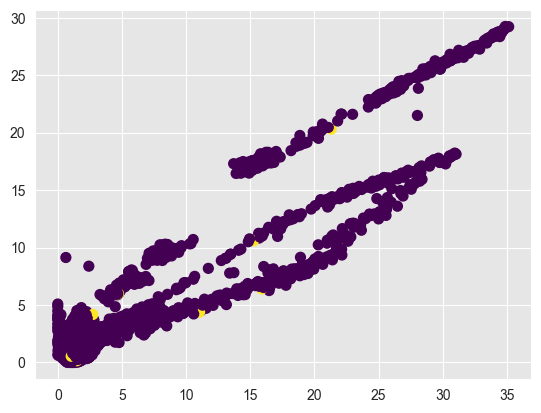

In [27]:
plt.scatter(x_train_representation[:, 0], x_train_representation[:, 1], c=y_train.numpy(), s=50, cmap='viridis')

In [28]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=SEED)
kmeans.fit(x_train_representation)
y_kmeans = kmeans.predict(x_train_representation)

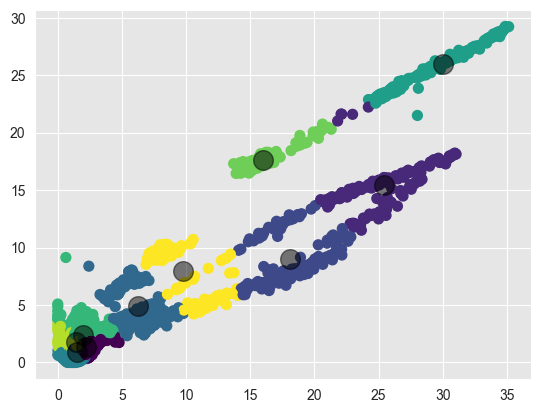

In [29]:
plt.scatter(x_train_representation[:, 0], x_train_representation[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [30]:
class FraudDataset(torch.utils.data.Dataset):
    
    def __init__(self, x, y):
        'Initialization'
        self.x = x
        self.y = y

    def __len__(self):
        'Returns the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample index
        if self.y is not None:
            return self.x[index].to(DEVICE), self.y[index].to(DEVICE)
        else:
            return self.x[index].to(DEVICE)

In [31]:
sf.seed_everything(SEED)

training_set_supervised = FraudDataset(x_train.to(DEVICE), y_train.to(DEVICE))
valid_set_supervised = FraudDataset(x_valid.to(DEVICE), y_valid.to(DEVICE))

training_generator_supervised,valid_generator_supervised = sf.prepare_generators(training_set_supervised,
                                                                              valid_set_supervised,
                                                                              batch_size=64)

model_supervised = sf.SimpleFraudMLPWithDropout(len(input_features), 1000, 0.2).to(DEVICE)
optimizer = torch.optim.Adam(model_supervised.parameters(), lr = 0.0001)
criterion = torch.nn.BCELoss().to(DEVICE)

model_supervised,training_execution_time,train_losses_dropout,valid_losses_dropout =\
    sf.training_loop(model_supervised,
                  training_generator_supervised,
                  valid_generator_supervised,
                  optimizer,
                  criterion,
                  verbose=True)


Epoch 0: train loss: 0.10162742840514356
valid loss: 0.03573565161150824
New best score: 0.03573565161150824

Epoch 1: train loss: 0.03880522776142219
valid loss: 0.026402932730671323
New best score: 0.026402932730671323

Epoch 2: train loss: 0.031078890040356588
valid loss: 0.023788555257806116
New best score: 0.023788555257806116

Epoch 3: train loss: 0.028793504393755692
valid loss: 0.02269559694591482
New best score: 0.02269559694591482

Epoch 4: train loss: 0.02777124553238599
valid loss: 0.02212640571285833
New best score: 0.02212640571285833

Epoch 5: train loss: 0.026878767767271123
valid loss: 0.021896383601693752
New best score: 0.021896383601693752

Epoch 6: train loss: 0.026169354435729566
valid loss: 0.021739529254413692
New best score: 0.021739529254413692

Epoch 7: train loss: 0.025671432849846024
valid loss: 0.021000032479457476
New best score: 0.021000032479457476

Epoch 8: train loss: 0.024933789431804836
valid loss: 0.021129466373412335
1  iterations since best scor

In [32]:
predictions = []

for x_batch, y_batch in valid_generator_supervised: 
    predictions.append(model_supervised(x_batch.to(DEVICE)).detach().cpu().numpy())

predictions_df=valid_df
predictions_df['predictions']=np.vstack(predictions)
    
sf.performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.861,0.647,0.277


In [33]:
loader_params = {'batch_size': 64,
                 'num_workers': 0}
    
training_generator = torch.utils.data.DataLoader(training_set, **loader_params)
valid_generator = torch.utils.data.DataLoader(valid_set, **loader_params)

train_reconstruction = sf.per_sample_mse(model, training_generator)
valid_reconstruction = sf.per_sample_mse(model, valid_generator)

train_df["reconstruction_error"] = train_reconstruction
valid_df["reconstruction_error"] = valid_reconstruction

In [34]:
class SimpleFraudMLPWithDropout(torch.nn.Module):
    
        def __init__(self, input_size, hidden_size,p):
            super(SimpleFraudMLPWithDropout, self).__init__()
            # parameters
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.p = p
            
            #input to hidden
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            #hidden to output
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
            
            self.dropout = torch.nn.Dropout(self.p)
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.relu(hidden)
            
            hidden = self.dropout(hidden)
            
            output = self.fc2(hidden)
            output = self.sigmoid(output)
            
            return output

In [35]:
sf.seed_everything(SEED)

input_features_new = input_features + ["reconstruction_error"]

# Rescale the reconstruction error
(train_df, valid_df)= sf.scaleData(train_df, valid_df, ["reconstruction_error"])

x_train_new = torch.FloatTensor(train_df[input_features_new].values)
x_valid_new = torch.FloatTensor(valid_df[input_features_new].values)

training_set_supervised_new = FraudDataset(x_train_new.to(DEVICE), y_train.to(DEVICE))
valid_set_supervised_new = FraudDataset(x_valid_new.to(DEVICE), y_valid.to(DEVICE))

training_generator_supervised,valid_generator_supervised = sf.prepare_generators(training_set_supervised_new,
                                                                              valid_set_supervised_new,
                                                                              batch_size=64)

model_supervised = SimpleFraudMLPWithDropout(len(input_features_new), 100, 0.2).to(DEVICE)
optimizer = torch.optim.Adam(model_supervised.parameters(), lr = 0.0001)
criterion = torch.nn.BCELoss().to(DEVICE)

model_supervised,training_execution_time,train_losses_dropout,valid_losses_dropout = \
    sf.training_loop(model_supervised,
                  training_generator_supervised,
                  valid_generator_supervised,
                  optimizer,
                  criterion,
                  verbose=True)

predictions = []
for x_batch, y_batch in valid_generator_supervised: 
    predictions.append(model_supervised(x_batch).detach().cpu().numpy())


Epoch 0: train loss: 0.32443885637685854
valid loss: 0.11727398761797472
New best score: 0.11727398761797472

Epoch 1: train loss: 0.08671466312611593
valid loss: 0.050744231888016716
New best score: 0.050744231888016716

Epoch 2: train loss: 0.05495493252090326
valid loss: 0.037147800522586684
New best score: 0.037147800522586684

Epoch 3: train loss: 0.045688614663694685
valid loss: 0.03199237373408154
New best score: 0.03199237373408154

Epoch 4: train loss: 0.04018814490002225
valid loss: 0.028909151681032173
New best score: 0.028909151681032173

Epoch 5: train loss: 0.03642611925037895
valid loss: 0.026787934170099476
New best score: 0.026787934170099476

Epoch 6: train loss: 0.033927855017972505
valid loss: 0.02538750051963525
New best score: 0.02538750051963525

Epoch 7: train loss: 0.032196791712586444
valid loss: 0.02462451847478788
New best score: 0.02462451847478788

Epoch 8: train loss: 0.031020861347410722
valid loss: 0.023899018844905123
New best score: 0.023899018844905

In [36]:
predictions_df=valid_df
predictions_df['predictions']=np.vstack(predictions)
    
sf.performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.862,0.651,0.274
